In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.externals import joblib

In [2]:
EPLData=pd.read_excel('4 Seasons 2016-20 EPL ML Data.xlsx')

In [3]:
#Function which uses simulation to generate accuracy of a model given a predictive distribution and actual distribution 

def NaiveBenchmark(NaiveProb_HW,NaiveProb_D,ActualResultDist):
    Results=['HW','D','HL']
    accuracy=[]
    NaiveProb_HL=1-NaiveProb_HW-NaiveProb_D
    for i in range(10000):
        actual=np.random.choice(Results,p=[NaiveProb_HW,NaiveProb_D,NaiveProb_HL])
        predicted=np.random.choice(Results,p=ActualResultDist)
        if predicted==actual:
            accuracy.append(1)
        else:
            accuracy.append(0)
    return sum(accuracy)/len(accuracy)
            

In [4]:
#Generate accuracy of Naive model - Predict each result 1/3rd of the time

ModelAccuracies={}

ActualResultDist=EPLData['Results'].value_counts()/len(EPLData['Results'].values)

ModelAccuracies['NaiveBenchmark']=NaiveBenchmark(0.33,0.33,ActualResultDist.values)

##             Data Exploration

Text(0.5, 1.0, 'Distribution of Game Results')

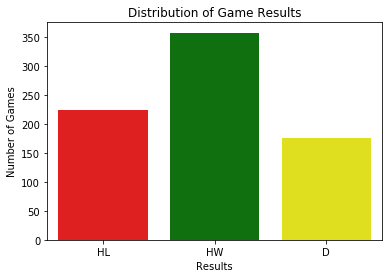

In [5]:
# Generate Result distribution plot

my_pal = {"HW":"green", "HL": "red", "D":"yellow"}

fig=sns.countplot(EPLData['Results'],palette=my_pal)
plt.xlabel("Results")
plt.ylabel("Number of Games")
plt.title("Distribution of Game Results")

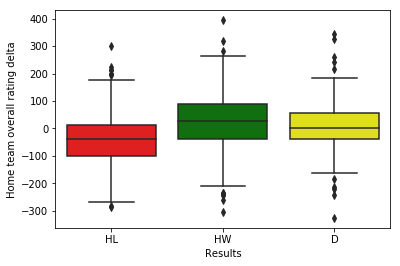

In [6]:
# Generate boxplot to see how Results vary with the Home team "overall" rating delta

sns.boxplot(EPLData['Results'],EPLData['overall'],palette=my_pal)
plt.xlabel("Results")
plt.ylabel("Home team overall rating delta")
plt.show()

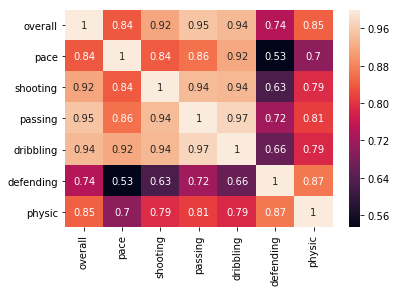

In [7]:
# Assess correlation in features

corr=EPLData.corr()
sns.heatmap(corr,annot=True)

In [8]:
# Create two buckets - Home win and No win (draw or loss)
# Use for future scenario

# EPLData.replace(['D','HL'],'NoWin',inplace=True)


## Prepare data for machine learning input format

In [9]:
# Create predictor features and target class vectors

X=EPLData.drop(columns=['Results'])

Y=EPLData['Results']

In [10]:
#Using 2/3rd - 1/3rd as training set - test set ratio 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1,stratify=Y)

In [11]:
# Standardize the features

from sklearn.preprocessing import RobustScaler
Scaler=RobustScaler()
X_train=Scaler.fit_transform(X_train) #Fit Scaler transformer on the training data and transform it

#Transform the test data using mapping from training data

X_test=Scaler.transform(X_test) 

In [12]:
# As seen in the correlation heatmap, the data is correlated 
# So we will utilize Principal Component Analysis (PCA) to reduce the dimentionality of the data and capture maximum variance

from sklearn.decomposition import PCA
pca=PCA(n_components=4)
pca.fit(X_train)    #Fit PCA transformer on training data
X_train=pca.transform(X_train) 

#Transform the test data using PCA component mapping from training data

X_test=pca.transform(X_test) 


print('Explained variance by PCA components is {0:.2f} %'.format(sum(pca.explained_variance_ratio_)*100))


Explained variance by PCA components is 98.46 %


## Train machine learning models

In [13]:
# Logistic Regeression


from sklearn.linear_model import LogisticRegression

LGmodel=LogisticRegression(class_weight="balanced",multi_class='auto',solver='lbfgs')

LGmodel.fit(X_train,y_train)

predictions=LGmodel.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions))

ModelAccuracies['Logistic Regression']=accuracy_score(y_test,predictions)

joblib.dump(LGmodel, "Trained Models\LogReg_model.pkl")

              precision    recall  f1-score   support

           D       0.31      0.28      0.29        58
          HL       0.51      0.65      0.57        74
          HW       0.61      0.55      0.58       119

   micro avg       0.51      0.51      0.51       251
   macro avg       0.48      0.49      0.48       251
weighted avg       0.51      0.51      0.51       251

0.5139442231075697


['Trained Models\\LogReg_model.pkl']

In [14]:
# Random Forests

from sklearn.ensemble import RandomForestClassifier
RFmodel=RandomForestClassifier(n_estimators=30,class_weight="balanced")
RFmodel.fit(X_train,y_train)
predictions=RFmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions))

ModelAccuracies['Random Forest']=accuracy_score(y_test,predictions)

joblib.dump(RFmodel, "Trained Models\RandomForest_model.pkl")


              precision    recall  f1-score   support

           D       0.29      0.19      0.23        58
          HL       0.52      0.46      0.49        74
          HW       0.56      0.69      0.62       119

   micro avg       0.51      0.51      0.51       251
   macro avg       0.45      0.45      0.44       251
weighted avg       0.48      0.51      0.49       251

0.5059760956175299


['Trained Models\\RandomForest_model.pkl']

In [15]:
#Support Vector Machines

from sklearn.svm import SVC
SVMmodel=SVC(class_weight="balanced")
SVMmodel.fit(X_train,y_train)
predictions=SVMmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions))

ModelAccuracies['SVM']=accuracy_score(y_test,predictions)

joblib.dump(SVMmodel, "Trained Models\SVM_model.pkl")


              precision    recall  f1-score   support

           D       0.33      0.57      0.42        58
          HL       0.60      0.57      0.58        74
          HW       0.63      0.43      0.51       119

   micro avg       0.50      0.50      0.50       251
   macro avg       0.52      0.52      0.50       251
weighted avg       0.55      0.50      0.51       251

0.50199203187251


C:\Users\okaak\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


['Trained Models\\SVM_model.pkl']

In [16]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB
NaiveBayesmodel=GaussianNB()
NaiveBayesmodel.fit(X_train,y_train)
predictions=NaiveBayesmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions))

ModelAccuracies['Naive Bayes']=accuracy_score(y_test,predictions)

joblib.dump(NaiveBayesmodel,r"Trained Models\NBayes_model.pkl")


              precision    recall  f1-score   support

           D       0.00      0.00      0.00        58
          HL       0.65      0.49      0.56        74
          HW       0.54      0.88      0.67       119

   micro avg       0.56      0.56      0.56       251
   macro avg       0.40      0.46      0.41       251
weighted avg       0.45      0.56      0.48       251

0.5617529880478087


C:\Users\okaak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\okaak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\okaak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['Trained Models\\NBayes_model.pkl']

## Train Neural Network



In [17]:
Seed=12345
import os
import random as rnd

os.environ['PYTHONHASHSEED']=str(Seed)
np.random.seed(Seed)
tf.random.set_seed(Seed)
rnd.seed(Seed)

In [18]:
# Convert target classes to numerical type for Neural network training

y_train.replace(['HW','D','HL'],[0,1,2],inplace=True)
y_test.replace(['HW','D','HL'],[0,1,2],inplace=True)

In [19]:
NNAcurracies=[] ## List to store Neural Network accuracies for multiple runs

for i in range(10):
    
    #Create Neural network with one Hidden layers

    model = tf.keras.models.Sequential()  
    model.add(tf.keras.layers.Flatten())  
    model.add(tf.keras.layers.Dense(150, activation=tf.nn.relu))  #Hidden layer
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax)) #Output layer

    #Compile model using the Adam optimiser

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy']) 

    #Train the model

    model.fit(X_train, y_train.values, epochs=20,verbose=0)  

    #Test NN model on out of sample data

    val_loss, val_acc = model.evaluate(X_test, y_test.values,verbose=0)  
    NNAcurracies.append(val_acc)


print(NNAcurracies)
print(sum(NNAcurracies)/len(NNAcurracies))

#  Record average accuracy of Neural network runs

ModelAccuracies['Neural Network']=sum(NNAcurracies)/len(NNAcurracies)

[0.56573707, 0.5697211, 0.57768923, 0.57768923, 0.5737052, 0.5697211, 0.5697211, 0.5816733, 0.58565736, 0.5816733]
0.5752988040447236


In [20]:
from keras.models import load_model

model.save(r'Trained Models\NNmodel.h5')

Using TensorFlow backend.


In [21]:
#Confusion matrix for the Neural Network model

from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool=np.where(y_pred_bool==0,'HW',(np.where(y_pred_bool==1,'D','HL')))

y_test.replace([0,1,2],['HW','D','HL'],inplace=True)


print(classification_report(y_test.values, y_pred_bool))

              precision    recall  f1-score   support

           D       1.00      0.02      0.03        58
          HL       0.64      0.55      0.59        74
          HW       0.56      0.87      0.68       119

   micro avg       0.58      0.58      0.58       251
   macro avg       0.73      0.48      0.44       251
weighted avg       0.69      0.58      0.51       251



## Result Evaluation and Benchmarking 

In [22]:
# Bookmaker odds from last 9 years data

ModelAccuracies['Betting Co Odds']=0.54

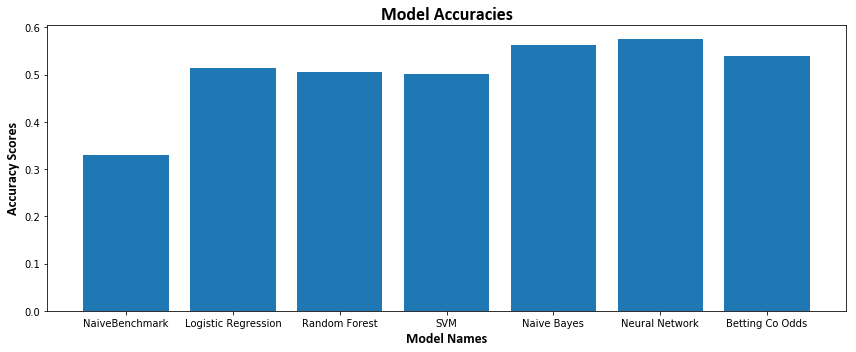

In [23]:
#Plot accuracy scores of different models

font = {'family': 'calibri',
        'weight': 'bold',
        'size': 14,
        }

fonttitle = {'family': 'calibri',
        'weight': 'bold',
        'size': 18,
        }
fig=plt.figure(figsize=(12,5))
plt.bar(ModelAccuracies.keys(),ModelAccuracies.values())
plt.xlabel("Model Names",fontdict=font)
plt.ylabel("Accuracy Scores",fontdict=font)
plt.title("Model Accuracies",fontdict=fonttitle)
plt.xticks
plt.tight_layout()
plt.show()


In [24]:
ModelAccuracies

{'NaiveBenchmark': 0.3294,
 'Logistic Regression': 0.5139442231075697,
 'Random Forest': 0.5059760956175299,
 'SVM': 0.50199203187251,
 'Naive Bayes': 0.5617529880478087,
 'Neural Network': 0.5752988040447236,
 'Betting Co Odds': 0.54}